# Imports

In [1]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if (IN_COLAB):
    !pip install pytorch_lightning -qqq
    !pip install neptune
    from google.colab import drive
    drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import neptune

In [4]:
%env NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE='TRUE'
run = neptune.init_run(
    project="lais-oliveira/IA901-Projfinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYmYzNTE1NS0zNzc4LTRmNTctOTIwZC0xNTEyZTRiMmFhMzEifQ==")  # your credentials

env: NEPTUNE_ALLOW_SELF_SIGNED_CERTIFICATE='TRUE'


<ipython-input-4-491e34e5bf7a>:2: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/lais-oliveira/IA901-Projfinal/e/IAP-1


In [5]:
# Redução das mensagens de log no terminal.
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [6]:
if (IN_COLAB):
    root = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/OASIS_slices2_flat_single_3classes'
else:
    root = '../../../data/interim/OASIS_slices2_flat_single_3classes'

In [8]:
def setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfList = []

    if(tfGrayscale):
        tfList.append(transforms.Grayscale(num_output_channels=3))

    if(tfRdRotate):
        tfList.append(transforms.RandomRotation(10))

    if (tfHzFlip):
        tfList.append(transforms.RandomHorizontalFlip())

    if (tfResize):
        tfList.append(transforms.Resize(224))

    if (tfCtrCrop):
        tfList.append(transforms.CenterCrop(224))

    tfList.append(transforms.ToTensor())

    if (tfNormalize):
        tfList.append(transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]))

    transform_lst = transforms.Compose(tfList)

    return transform_lst

In [9]:
def transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfText = "Base"

    if(tfGrayscale):
        tfText = tfText + "+Grayscale"

    if(tfRdRotate):
        tfText = tfText + "+Random Rotation"

    if (tfHzFlip):
        tfText = tfText + "+Random Hz Flip"

    if (tfResize):
        tfText = tfText + "+Resize"

    if (tfCtrCrop):
        tfText = tfText + "+Center Crop"

    if (tfNormalize):
        tfText = tfText + "+Normalization"

    return tfText

In [10]:
from collections import Counter

dataset0=datasets.ImageFolder(root=root,transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

print("Número de amostras por classe: ", dict(Counter(dataset0.targets)))

414
['MildDemented', 'NonDemented', 'VeryMildDemented']
3
Número de amostras por classe:  {0: 28, 1: 316, 2: 70}


In [11]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform, batch_size):
        super().__init__()
        self.root_dir = root
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_val = int(0.1 * n_data)
        n_test = n_data - (n_train + n_val)

        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset

    def test_dataloader(self):
        return self.test_dataset

In [12]:
# Datamodule baseados nas transformações

batch_size = 32
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

# Vizualizando imagens

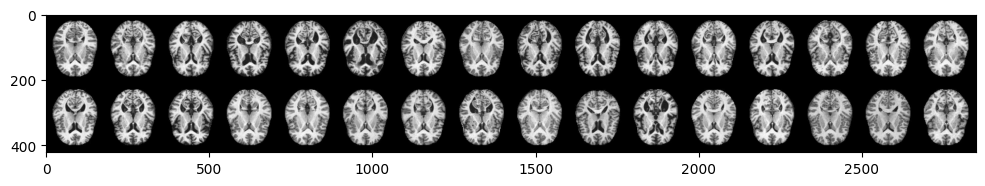

In [13]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Definindo e treinando o modelo base: AlexNet

In [14]:
print(len(class_names))

3


## Funções para definição do modelo, treinamento, testes e métricas

In [15]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

class MyModel(LightningModule):

    def __init__(self, lr):
        num_classes = len(class_names)
        super().__init__()
        self.lr = lr
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs,len(class_names))

        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        output = self.train_metrics(pred, y)

        run["train/loss"].append(loss)
        run["train/acc"].append(acc)
        run["train/multiclassacc"].append(output["train_MulticlassAccuracy"])

        self.log("train_loss", loss)
        self.log("train_acc", acc)
        self.log_dict(output)

        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        output = self.val_metrics(pred, y)

        run["val/loss"].append(loss)
        run["val/acc"].append(acc)
        run["val/multiclassacc"].append(output["val_MulticlassAccuracy"])

        self.log("val_loss", loss)
        self.log("val_acc", acc)
        self.log_dict(output)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]

        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))

        output = self.test_metrics(pred, y)

        self.log("test_loss", loss)
        self.log("test_acc", acc)
        self.log_dict(output)


In [16]:
def train_model(model, epochs, datamodule):

    trainer = pl.Trainer(max_epochs=epochs)
    trainer.fit(model, datamodule)

    val_loader = datamodule.val_dataloader()
    trainer.validate(dataloaders=val_loader)

    return trainer

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_matrix(title, model):

    ax = plt.subplot()
    cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

    sns.set_style("darkgrid")
    sns.set(rc={"figure.figsize":(20, 4)})
    colormap = sns.color_palette("Blues",12)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)

    # labels, title and ticks
    ax.set_xlabel('Predições:')
    ax.set_ylabel('Labels:')
    ax.set_title(title);
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation=0)

In [18]:
def test_model(model, datamodule, trainer, tfText):
    print("Modelo: " + tfText)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

    plot_matrix("Modelo: "+ tfText, model)

## Treinamento e Teste dos Modelos

In [19]:
batch_size = 32
epochs = 50

## Teste de Taxa de Aprendizado

In [20]:
# Learning Rate
lr = 0.0001

# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize) + "LR: " + str(lr)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel(lr)

# Treinamento e Validação
tr = train_model(model, epochs, datamodule)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val_MulticlassAccuracy   │     0.510569155216217     │
│  val_MulticlassPrecision  │    0.6319783329963684     │
│   val_MulticlassRecall    │     0.510569155216217     │
│          val_acc          │    0.9024389982223511     │
│         val_loss          │    0.2849888205528259     │
└───────────────────────────┴───────────────────────────┘

Modelo: BaseLR: 0.0001


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.3971957564353943     │
│ test_MulticlassPrecision  │    0.4368782937526703     │
│   test_MulticlassRecall   │    0.3971957564353943     │
│         test_acc          │    0.6904761791229248     │
│         test_loss         │    0.7283541560173035     │
└───────────────────────────┴───────────────────────────┘

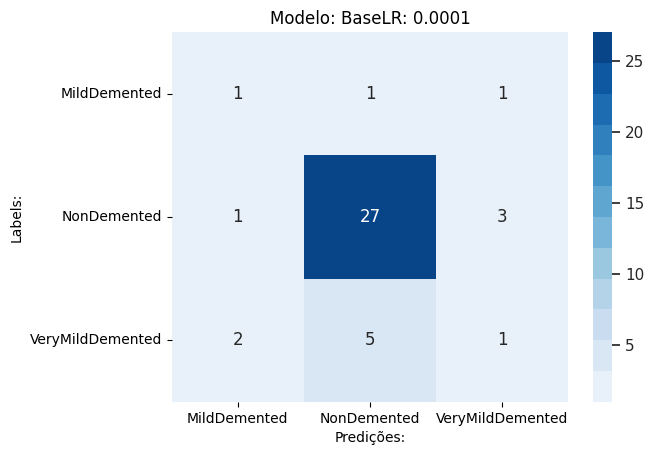

In [21]:
# Testando a base dos testes
test_model(model, datamodule, tr, tf_text)

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/fabiogr/Projeto-IA901/e/IA901-19/metadata
